## ICSI corpus. 
Go through the list of files and extract passage and the summaries, using the DialogueActs as intermediary
Uses the following mappings:

__1__) meeting id -> ordered dict of word id: word

__2__) meeting id -> ordered dict of dialog id -> list of (start, end) word ids that form a dialog. 

__3__) summary_starts, summary_ends -> sets of start and end dialog ids that belong to extractive summaries


function `get_words(meeting, start_word=None, end_word=None)` # goes through the meeting and returns words from start to end if provided. Else prints everything

function `extract_dialogues(meeting)` # goes through the meeting and returns list of  (dialogue, SummaryFlag) for the meeting


In [1]:
import glob, os
#import xml.etree.ElementTree as et
from lxml import etree as et
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import numpy as np
ROOT_DIR = "/home/rajivn/W266/W266-fall-2020-hwu-rnair/data/ICSI_plus_NXT/ICSIplus"

### Extract words

__1__) meeting id -> ordered dict of word id: word

In [2]:
meeting_dict = dict() # key = meeting, value = ordered dict of word id: word
cur_word = None
for word_f in sorted(glob.glob(ROOT_DIR+"/Words/*xml")):
    m = word_f.split("/")[-1].split(".")
    meeting_name = m[0]+"."+m[1]
    root = et.parse(word_f).getroot()
    nodes = root.findall('*')
    meet_words = OrderedDict()

    for node in nodes:
        if node.tag=='w':
            meet_words[node.attrib['{http://nite.sourceforge.net/}id']] = node.text
            cur_word = node.text
        for w in node.values():
            if "disfmarker" in w or "pause" in w or "vocalsound" in w:
                meet_words [node.attrib['{http://nite.sourceforge.net/}id']] = None
    meeting_dict[meeting_name] = meet_words
    
#meeting_dict['Bdb001.D']['Bdb001.w.2,391']

In [3]:
def get_words(meeting, start=None, end=None):
    ret = ""
    include = False
    if start is None:
        include = True

    for meet_word in meeting_dict[meeting].keys():

        if start is not None and meet_word == start:
            include = True
        if include:
            if meeting_dict[meeting][meet_word] is not None:
                ret += meeting_dict[meeting][meet_word] + " "
        if end is not None and meet_word == end:
            include = False

    return ret

get_words('Bdb001.A', "Bdb001.w.915", "Bdb001.disfmarker.49")
#get_words('Bns002.D')

"So you 're essentially defining a lattice . Yeah . How - how Oh , that 's "

### Extract Dialogues

__2__) meeting id -> ordered dict of dialog id -> tuple of (start, end) word ids that form a dialog. 

In [4]:
meeting_dialogues = dict() # key = meeting name, value = ordered dict of dialog id -> List of (start, end, SummaryFlag) word ids that form a dialog. 
for dialog_f in sorted(glob.glob(ROOT_DIR+"/DialogueActs/*acts.xml")):
    m = dialog_f.split("/")[-1].split(".")
    meeting_name = m[0]+"."+m[1]
    root = et.parse(dialog_f).getroot()
    dlist = root.findall('dialogueact')
    for dl in dlist:
        nodes = dl.findall("{http://nite.sourceforge.net/}child")
        dialog_id = dl.attrib['{http://nite.sourceforge.net/}id']

        for dl_c in nodes:
            words = dl_c.attrib['href']
            words = words.split("#")[1]
            try:
                start, end = words.split("..")
                start, end = start.replace("id", ""), end.replace("id", "")
                start, end = start.replace("(", ""), end.replace("(", "")
                start, end = start.replace(")", ""), end.replace(")", "")
            except:
                start = end = words.replace("id", "").replace("(", "").replace(")", "")
            if meeting_name not in meeting_dialogues:
                meeting_dialogues[meeting_name] = OrderedDict()
            meeting_dialogues[meeting_name][dialog_id] = [start, end, None]



### Extract summaries

__3__) meeting id -> set of dialog ids that belong to extractive summaries

In [5]:
summary_starts, summary_ends = set(),set() # key = meeting name, list (2) of set of Dialogue starts and ends

for dialog_f in sorted(glob.glob(ROOT_DIR+"/Contributions/Summarization/extractive/*extsumm.xml")):
    m = dialog_f.split("/")[-1].split(".")
    meeting_name = m[0]+"."+m[1]
    root = et.parse(dialog_f).getroot()
    dlist = root.findall('extsumm/{http://nite.sourceforge.net/}child')
    for dl in dlist:
        dialogs = dl.attrib['href']
        dialogs = dialogs.split("#")[1]
        start = end = None
        try:
            start, end = dialogs.split("..")
            start, end = start.replace("id", ""), end.replace("id", "")
            start, end = start.replace("(", ""), end.replace("(", "")
            start, end = start.replace(")", ""), end.replace(")", "")
        except:
            start = end = dialogs.replace("id", "").replace("(", "").replace(")", "")
        summary_starts.add(start)
        summary_ends.add(end)

In [6]:
def extract_dialogues(meeting):
    # loop through all the meetings and (optionally) return only the ones that fall in range of starts/ends
    ret = []
    dialogues = meeting_dialogues[meeting]
    include = False
    for dialog, (start_w, end_w, _) in dialogues.items():
        if dialog in summary_starts:
            include = True
        if include:
            ret.append((dialog, start_w, end_w, get_words(meeting, start_w, end_w), True))
            meeting_dialogues[meeting][dialog][2] = True
        else:
            ret.append((dialog, start_w, end_w, get_words(meeting, start_w, end_w), False))
            meeting_dialogues[meeting][dialog][2] = False
        if dialog in summary_ends:
            include = False
    return ret


In [7]:
#extract_dialogues('Bns002.D')


In [8]:
# go through all meetings and write out dialogues to files
diags=[]
for meeting in meeting_dialogues.keys():
    with open("../data/ICSI_plus_NXT/processing/"+meeting+"_summaries.txt", "w") as f:
        for _, _, _, diag, summ_flag in extract_dialogues(meeting):
            diags.append(diag)
            f.write(diag)
            f.write("|")
            f.write(str(int(summ_flag)))
            f.write("\n")


479

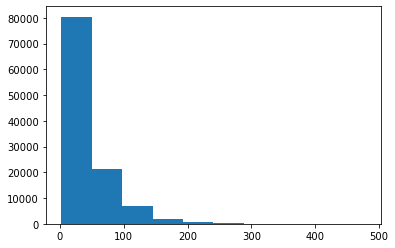

In [9]:
sents = []
n_sents = []
for dia in diags:
    if len(dia) > 1000:
        print (dia)
        break
    n_sents.append(len(dia))

plt.hist(np.array(n_sents))

max(np.array(n_sents))